In [63]:
from IPython.core.display import HTML
style = """
<style>
div.output_area {
    overflow-y: scroll;
}
div.output_area img {
    max-width: unset;
}
</style>
"""
HTML(style) 


In [317]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import random
import math
import numpy as np
import operator
from functools import reduce
from scipy import ndimage
from scipy.spatial import KDTree
from webcolors import (rgb_to_name, CSS3_HEX_TO_NAMES, hex_to_rgb)
from scipy.spatial import KDTree
from colorsys import rgb_to_hsv
flat_map = lambda f, xs: reduce(lambda a, b: a + b, map(f, xs), [])


In [376]:
NOTES = ["c", "d" ,"ef", "f", "g", "af", "bf"]
OCTAVES = range(3, 7)

In [326]:
# Adapted from https://medium.com/codex/rgb-to-color-names-in-python-the-robust-way-ec4a9d97a01f
color_names = []
color_rgb_values = []
for color_hex, color_name in CSS3_HEX_TO_NAMES.items():
    color_names.append(color_name)
    color_rgb_values.append(hex_to_rgb(color_hex))
colors_kdt = KDTree(color_rgb_values)

def convert_rgb_to_names(rgb_tuple):    
    distance, index = colors_kdt.query(rgb_tuple)
    return color_names[index]

In [327]:
def printI(img, size=16):
    fig= plt.figure(figsize=(size, size))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    

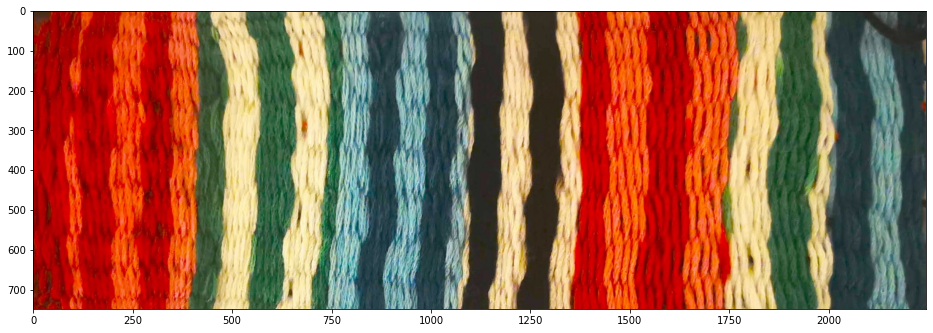

In [328]:
img= cv2.imread("img/weave_1.jpg")
printI(img)

In [347]:
def recursive_subdivide(node, k, minPixelSize, img, level=1):

    if node.get_error(img)<=k:
        return
    w_1 = int(math.floor(node.width/2))
    w_2 = int(math.ceil(node.width/2))
    h_1 = int(math.floor(node.height/2))
    h_2 = int(math.ceil(node.height/2))


    if w_1 <= minPixelSize or h_1 <= minPixelSize:
        return
    node.nw = Node(node.x0, node.y0, w_1, h_1, level) # top left
    recursive_subdivide(node.nw, k, minPixelSize, img, level+1)

    node.ne = Node(node.x0 + w_1, node.y0, w_2, h_1, level)# top right
    recursive_subdivide(node.ne, k, minPixelSize, img, level+1)
    
    node.sw = Node(node.x0, node.y0+h_1, w_1, h_2, level) # btm left
    recursive_subdivide(node.sw, k, minPixelSize, img, level+1)

    node.se = Node(node.x0+w_1, node.y0+h_1, w_2, h_2, level) # btm right
    recursive_subdivide(node.se, k, minPixelSize, img, level+1)



class Node():
    def __init__(self, x0, y0, w, h, l):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.level = l
        self.nw = None
        self.ne = None
        self.se = None
        self.sw = None
   
    def reset_level(self, level=0):
        node =  Node(self.x0, self.y0, self.width, self.height, level)
        node.nw = self.nw.reset_level(level+1) if self.nw != None else None
        node.ne = self.ne.reset_level(level+1) if self.ne != None else None
        node.sw = self.sw.reset_level(level+1) if self.sw != None else None
        node.se = self.se.reset_level(level+1) if self.se != None else None
        return node

    def get_descendents(self):
        if self.is_leaf():
            return [self];
        else:
            return flat_map(lambda c: c.get_descendents(), self.get_children())

    def get_children(self):
        return list(filter(None, [ self.nw, self.ne, self.se, self.sw ]))
    
    def is_leaf(self):
        return len(self.get_children()) == 0
    
    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self, img):
        return img[self.y0:self.y0+self.get_height(), self.x0:self.x0 + self.get_width()]
    
    def get_avg_color(self):
        pixels = self.get_points(img)
        gAvg = math.floor(np.mean(pixels[:, :, 0]))
        rAvg = math.floor(np.mean(pixels[:, :, 1]))
        bAvg = math.floor(np.mean(pixels[:, :, 2]))
        return (gAvg, rAvg, bAvg)
    
    def get_error(self, img):
        pixels = self.get_points(img)
        b_avg = np.mean(pixels[:,:,0])
        b_mse = np.square(np.subtract(pixels[:,:,0], b_avg)).mean()
    
        g_avg = np.mean(pixels[:,:,1])
        g_mse = np.square(np.subtract(pixels[:,:,1], g_avg)).mean()
        
        r_avg = np.mean(pixels[:,:,2])
        r_mse = np.square(np.subtract(pixels[:,:,2], r_avg)).mean()
       
        # Weights from the BT.601 Intensity formula: https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion
        e = r_mse * 0.2989 + g_mse * 0.5870 + b_mse * 0.1140
        
        # What's this big number?
        return (e * img.shape[0]* img.shape[1])/90000000
    
    def render_image(self, imgOut, img, outlineLevel=None, offsetX=0, offsetY=0):
        if self.is_leaf():
            (gAvg, rAvg, bAvg) = self.get_avg_color()
            imgOut[offsetY:offsetY+self.get_height(), offsetX:offsetX+self.get_width(), 0] = gAvg
            imgOut[offsetY:offsetY+self.get_height(), offsetX:offsetX+self.get_width(), 1] = rAvg
            imgOut[offsetY:offsetY+self.get_height(), offsetX:offsetX+self.get_width(), 2] = bAvg
        else:
            self.nw.render_image(imgOut, img, outlineLevel, offsetX, offsetY)
            self.ne.render_image(imgOut, img, outlineLevel, offsetX+self.nw.get_width(), offsetY)
            self.sw.render_image(imgOut, img, outlineLevel, offsetX, offsetY+self.nw.get_height())
            self.se.render_image(imgOut, img, outlineLevel, offsetX+self.sw.get_width(), offsetY+self.ne.get_height())
        
        if outlineLevel is None or self.level <= outlineLevel:
            imgOut = cv2.rectangle(imgOut, (offsetX, offsetY), (offsetX+self.get_width(), offsetY + self.get_height()), (0,0,0), 1)
        
      

In [348]:
class QTree():
    def __init__(self, img, threshold=7, min_size=3):
        self.threshold = threshold
        self.min_size = min_size
        self.img = img
        self.root = Node(0, 0, img.shape[1], img.shape[0], 0)
        
    def get_points(self): 
        return img[self.root.y0:self.root.y0+self.root.get_height(), self.root.x0:self.root.x0 + self.root.get_width()]
   
    def get_nodes_at_level(self, level):
        i = 0;
        nodes = [self.root]
        while i < level:
            nodes = flat_map(lambda n: n.get_children(), nodes)
            i += 1
        return nodes
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold, self.min_size, self.img)
        
    def render_image(self, outlineLevel = None):
        imgOut = np.zeros((self.img.shape[0], self.img.shape[1], 3), np.uint8)
        self.root.render_image(imgOut, self.img, outlineLevel);
        return imgOut;
    
    def level_for_max_prop(self, prop):
        getProp = operator.attrgetter(prop)
        return max(((n.level, getProp(n)) for n in self.root.get_descendents() if n.is_leaf()), key=lambda p: p[1])[0]
        

In [374]:
class Bar():
    def __init__(self, node):
        self.node = node
        
    def get_width(self):
        return self.node.get_width()
        
    def get_height(self):
        return self.node.get_height()
    
    def is_leaf(self):
        return self.node.is_leaf()
    
    def ne(self):
        return Bar(self.node.ne)
    
    def nw(self):
        return Bar(self.node.nw)
    
    def sw(self):
        return Bar(self.node.sw)
    
    def se(self):
        return Bar(self.node.se)
    
    def to_tidal(self):
        if self.is_leaf():
            (g, r, b) = self.node.get_avg_color()
            # print((r, g, b))
            # Why is this round the wrong way? no idea, that's why. It doesn't matter though for our purposes.
            (hue, sat, val) = rgb_to_hsv(b, r, g)
            note = NOTES[math.floor(hue * len(NOTES))]
            octave = OCTAVES[math.floor(val / 255.0 * len(OCTAVES))]
            return "%s%s" % (note, octave)
        else: 
            return "{[%s %s] , [%s %s]}" % (self.ne().to_tidal(), self.nw().to_tidal(), self.se().to_tidal(), self.sw().to_tidal())
        
    def render_image(self, imgOut, img, outlineLevel=None, offsetX=0, offsetY=0):
        self.node.render_image(imgOut, img, outlineLevel, offsetX, offsetY)

class Sequence():
    def __init__(self, tree):
        level = tree.level_for_max_prop("height")
        self.bars = []
        self.img = tree.img
        nodes = tree.get_nodes_at_level(level)
        nodes.sort(key=lambda n: n.y0 * img.shape[1] + n.x0)
        for node in nodes:
            node = node.reset_level()
            self.bars.append(Bar(node))
     
    
    def to_tidal(self):
        return "[%s]/%s" % (" ".join(bar.to_tidal() for bar in self.bars), len(self.bars))
        
        
    def render_image(self):
        width = self.bars[0].get_width() * len(self.bars)
        height = self.bars[0].get_height() 
        imgOut = np.zeros((height, width, 3), np.uint8)
        left = 0
        for bar in self.bars:
            bar.render_image(imgOut, self.img, None, left)
            imgOut = cv2.rectangle(imgOut, (left, 0), (left + bar.get_width(), bar.get_height()), (0, 0, 0), 2)
            left += bar.get_width()
        return imgOut

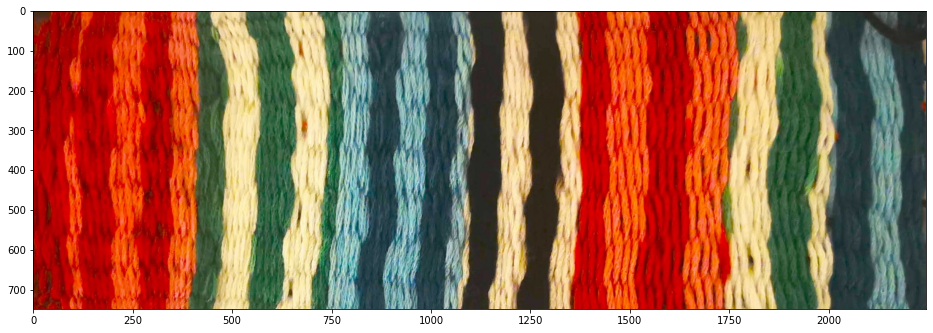

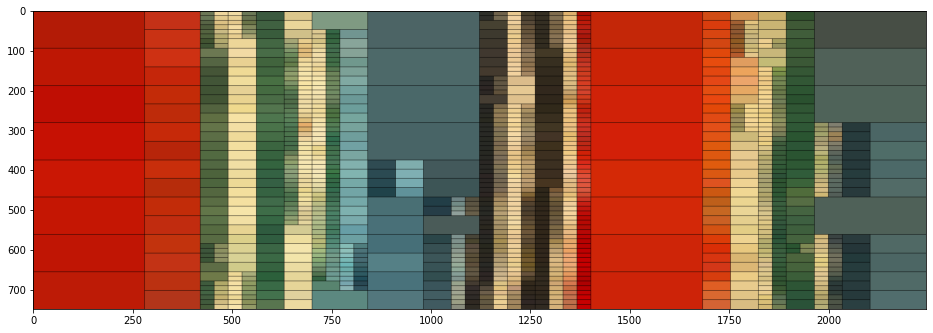

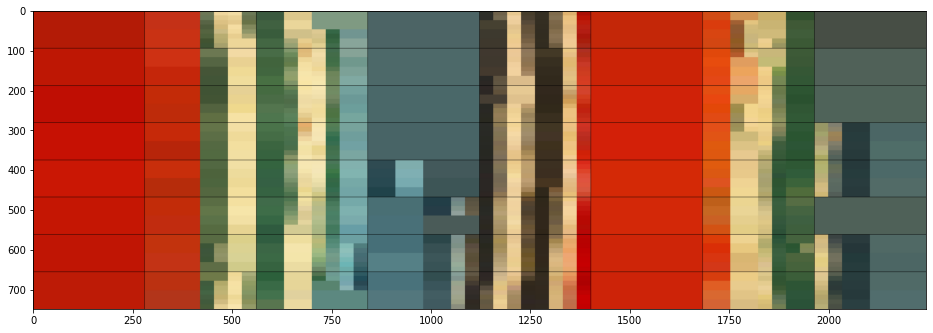

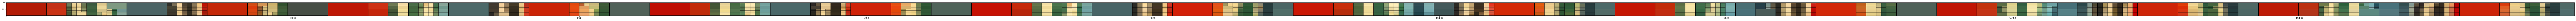

In [377]:
tree = QTree(img, threshold=50, min_size=10)
tree.subdivide()
sequence = Sequence(tree)
printI(img)
printI(tree.render_image())
printI(tree.render_image(outlineLevel=3))
printI(sequence.render_image(), size=200)

In [378]:
sequence.to_tidal()

'[c5 {[{[{[d4 c6] , [d4 c6]} {[c6 d4] , [c6 d4]}] , [{[d4 c6] , [d5 c6]} {[c6 d4] , [c6 d4]}]} c6] , [{[{[d5 c6] , [d5 c6]} {[c6 d4] , [c5 d4]}] , [c6 {[d5 d4] , [d5 d4]}]} c6]} {[ef5 {[c6 ef4] , [c6 ef4]}] , [{[f5 {[ef4 c6] , [ef4 c6]}] , [f5 {[ef4 c6] , [ef4 c6]}]} {[c6 ef4] , [{[c6 d5] , [c6 d5]} ef4]}]} f4 {[{[{[c5 c6] , [c5 c6]} {[c5 c3] , [c5 c3]}] , [{[c5 c6] , [c5 c6]} {[c4 c3] , [c4 c3]}]} {[{[c4 c6] , [c4 c6]} {[c4 d3] , [c4 d3]}] , [{[c4 c6] , [c4 c6]} c4]}] , [{[{[c5 c6] , [c5 c6]} {[c5 c3] , [c5 c3]}] , [{[c5 c6] , [c5 c6]} {[c5 c3] , [c4 c3]}]} {[{[c4 c6] , [c4 c6]} c3] , [{[c4 c6] , [c5 c6]} c3]}]} c6 {[{[ef4 c6] , [ef4 c6]} {[c6 c6] , [{[c6 c5] , [c6 c5]} c6]}] , [{[ef4 c6] , [ef4 {[d5 c6] , [d5 c6]}]} {[{[c6 c5] , [c6 c5]} c6] , [{[c6 c5] , [c6 c5]} c6]}]} ef4 c5 {[{[c6 d4] , [c6 d4]} c6] , [{[c6 d4] , [c6 d4]} c6]} {[{[f5 {[ef4 c6] , [ef4 c6]}] , [f5 {[ef4 c6] , [ef4 c6]}]} {[{[c6 d5] , [c6 d5]} ef4] , [{[c6 d4] , [c6 d4]} ef4]}] , [{[f5 {[ef4 c6] , [d5 c6]}] , [f5 {[